# Parameter Selection for the Functionally Assembled Terrestrial Ecosystem Simulator

__Summary__<br>
Numerical, process-based models that simulate tropical forest ecosystem dynamics, such as the Functionally Assembled Terrestrial Ecosystem Simulator (FATES), have been proposed as a way to improve climate change projections. However, parameterizing these complex models is challenging due to their numerous and interconnected non-linear relationships. Here, we to identify three high-performing parameter sets for use in future FATES simulations by quantitatively evaluating the performance of nearly 300 simulations, each run with a unique parameter set, against observations at a tropical forest test site.

__Motivation__<br>
Greenhouse gas emissions from human activities are warming the Earth with potentially catastrophic implications for human health. Projections of twenty-first century warming are critical for climate change mitigation and adaptation efforts. Unfortunately, the numerical models used to project future climate differ in their predictions of warming even for the same greenhouse gas emissions scenario. This variability in projections across models stems largely from uncertainty about how Earth's vegetation will respond to climate change. In particular, predictions of tropical forest responses to climate change must be improved, as these forests exert strong control over global climate.  Numerical, process-based models of vegetated ecosystem dynamics, such as the Functionally Assembled Terrestrial Ecosystem Simulator (FATES; Fisher et al., 2015, 2018), have been proposed as a way of improving projections of tropical forests and thus future climate. However, parameterizing these complex models remains challenging due to their numerous parameters and interconnected, non-linear relationships.

__Goal__<br>
The goal of this analysis is to identify model parameter sets that allows the FATES model to best match observations of tropical forest structure and functioning at a test site.

__Methods__<br>
This analysis identifies high-performing parameter sets for use in future experiments by quantitatively evaluating the performance of nearly 300 different FATES parameter sets against observations at a tropical forest test site, Barro Colorado Island, Panama. 

_Parameter ensemble simulations_<br>
Prior to this analysis, we ran an ensemble of FATES simulations at our test site, Barro Colorado Island, Panama. Each simulation in the ensemble was initialized with a unique parameter set but was otherwise set-up identically to all other simulations. The 287 parameter sets we tested differed in 12 key plant trait parameters, which were sampled from observed distributions when possible (following Koven et al., _in prep_). All simulations were forced with repeating meteorological data for Barro Colorado Island, Panama, from the years 2003 to 2016 (Faybishenko et al., 2018). See Kovenock (2019) for further details of the parameter ensemble simulations.

Plant structure and functioning are sensitive to atmospheric carbon dioxide concentration, which increased over the observational time period. We therefore repeat all parameter ensemble simulations and our analysis below for two carbon dioxide concentrations that approximately bookend the observational time period (367ppm and 400ppm carbon dioxide).

_Parameter set evaluation and selection_<br>
This code uses the above ensemble of simulations to quantitatively evaluate the performance of each parameter set against observations of six variables at our tropical forest test site. These variables characterize ecosystem structure (leaf area index, above-ground biomass, basal area) and functioning (gross primary productivity, latent heat flux, sensible heat flux). Observations come from the following sources:  leaf area index from Detto et al. (2018); above-ground biomass from Meakem et al. (2018), Feeley et al. (2007), and Baraloto et al. (2013); basal area from Condit et al. (2017, 2012), Condit (1998), and Hubbell et al. (1999); and gross primary productivity, latent heat flux, and sensible heat flux from Koven et al. (in prep). As some of these data sets require permission to use or are not yet publicly available, observational data sets are not included for download here.

We use two performance metrics $-$ error rate and normalized root mean square error $-$ to quantify each parameter set's performance. The error rate measures how frequently the model output falls within the observed range for each variable. The normalized root mean square error measures the distance between the model output and the observed mean, relative to the observed range for each variable. The expectation is that high-performing parameter sets will result in model output that falls within the range of observations (low error rate) and near the observed mean (low normalized root mean square error). After evaluating a parameter set's performance for each individual variable, we calculate the weighted average performance across all variables for that parameter set. To ensure that our selection of a high-performing parameter set is robust to weighting method, we consider three different weighting approaches:  even weighting, weighting favoring structural variables, and weighting accounting for correlation between individual variable performance.

Lastly, we identify parameter sets for use in future experiments by assigning an overall rank to each parameter set based on its performance across both performance metrics, three weighted averaging approaches, and two background carbon dioxide concentrations.

__Results__<br>
This analysis identifies three high-performing parameter sets for use in future FATES simulations. We recommend the highest-performing parameter set for use in primary experiments and the next two highest-performing parameter sets for use in parameter sensitivity tests. These high-performing parameter sets are publicly available through the University of Washington ResearchWorks digital repository at http://hdl.handle.net/1773/43779. The performance of these parameter sets is reported in further detail in the [Results](#Results) section below and in Kovenock (2019).


## Analysis
## Step 1: Load libraries

In [1]:
import netCDF4 as nc4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats

## Step 2: Load and preprocess data

Here we load the data and calculate time series of annual mean values for six ecosystem characteristics for all the simulations and observations. This code section returns two multidimensional arrays, one for model output and one for observations, that contain annual mean values for each variable organized by parameter set and background carbon dioxide concentration.

The six ecosystem characteristics included in these arrays are:

- Leaf area index,
- Above-ground biomass,
- Basal area,
- Gross primary productivity,
- Latent heat flux, and
- Sensible heat flux.

### 2.1  Model output

This part of the code loads the model output for all FATES simulations in our parameter ensemble. Then it calculates time series of annual mean values for the six variables we use to evaluate the performance of each parameter set.

In [2]:
def annmeants(filepath,var,varfiletype,nyrs,conv_factor):
    ''' Calculate time series of annual means for a model output variable.
    :param filepath (str): file path to data file
    :param var (str): name of variable to call from filename
    :param nyrs (int, float): number of years to analyze
    :param conv_factor (float): conversion factor specific to variable specified by var
    :return: 2-D array containing annual mean time series (ensemble member, nyrs)
    '''
    
    # If model output is stored as monthly average for all tree sizes,
    # need to calculate annual mean.   
    if varfiletype == 0:
        
        # Load monthly time series
        # For all cases except latent heat flux (FLH):
        if var != 'FLH':
            mthts_temp = nc4.Dataset(filepath).variables[var][:,:,0]
        
        # For the special case of latent heat flux:
        elif var == 'FLH':
            # Sum of three terms:
            mthts_temp = (nc4.Dataset(filepath).variables['FCTR'][:,:,0] 
                          + nc4.Dataset(filepath).variables['FGEV'][:,:,0] 
                          + nc4.Dataset(filepath).variables['FCEV'][:,:,0])
        
        
        # Calculate annual mean time series for nyrs and convert units if necessary
        annmeants = np.nanmean(np.reshape((mthts_temp[:,int(-1*nyrs*12):] * conv_factor),
                                          (mthts_temp.shape[0],-1,12)),axis=2)
        
    # Else if model output is stored as annual mean but structured by tree size,
    # need to sum across tree sizes.
    elif varfiletype == 1:
        # Calculate annual mean time series for entire ecosystem by summing across tree sizes
        annmeants = np.squeeze(np.nansum((
                        nc4.Dataset(filepath).variables[var + '_SCLS'][:,int(-1*nyrs):,:]),
                        axis=2))
    
    mthts_temp = None
    
    return annmeants

First, we will specify the information required to load and calculate annual mean time series of model output for each simulation, including file paths and names, variables to analyze, and conversion factors.

In [3]:
# Filepath
model_filepath = 'data/'

# Filenames
# {1} = carbon dioxide concentration specified by CO2level;
# {2} = variable file type specified by varfiletype.
model_filenames =[
    'fates_clm5_fullmodel_bci_parameter_ensemble_1pft_slaprofile_{}_v001.I2000Clm50FatesGs.Cdf9b02d-Fb178808.2018-07-27.h{}.ensemble.sofar.nc',
    'fates_clm5_fullmodel_bci_parameter_ensemble_1pft_slaprofile_{}_v001.I2000Clm50FatesGs.Cdf9b02d-Fb178808.2018-07-27.h{}.ensemble.sofar.nc']

# Background carbon dioxide (CO2) concentration
CO2levels = ['367ppm', '400ppm']

# Variable list for model output
varlist = ['TLAI','AGB','BA','GPP','FLH','FSH']

# Data structure for each variable in varlist:
# 0 = monthly data for entire ecosystem;
# 1 = annual data structured by tree size structure.
varfiletype = [0,1,1,0,0,0]

# Conversion factor for each variable in varlist:
varconv = [1, 1, 1, 86400*365, 1, 1]

# Variable units after applying conversion factor for each variable in varlist:
varunits = ['$m^2/m^2$','$kgC/m^2$','$m^2/ha$','$gC/m^2/yr$','$W/m^2$','$W/m^2$']

# Number of years of model output to analyze
nyrs = 50

# Number of parameter sets in ensemble
nens = nc4.Dataset(model_filepath + model_filenames[0].format(CO2levels[0],varfiletype[0])).variables[varlist[0]].shape[0]

Next, we create a multidimensional array that contains a time series of annual means for each variable, parameter set and background carbon dioxide concentration.

In [4]:
# Return model_data (float): a 4-D array of annual mean values for
    # each variable with dimensions
    # (CO2levels, varlist, nens, nyrs)
    # with the following indexing:
    # CO2levels: 
    #         0 = 367ppm CO2; 
    #         1 = 400ppm CO2.
    # varlist: 
    #         0 = Leaf area index;
    #         1 = Above ground biomass;
    #         2 = Basal area;
    #         3 = Gross primary productivity;
    #         4 = Latent heat flux;
    #         5 = Sensible heat flux.
    # nens: 
    #         0:286 = parameter set index.

# Initialize array
model_data = np.zeros([len(CO2levels), len(varlist), nens, nyrs])

for c in range(len(CO2levels)):
    for v in range(len(varlist)):
        
        filepath = model_filepath + model_filenames[c].format(CO2levels[c],varfiletype[v])
        
        model_data[c, v, :, :] = annmeants(filepath, varlist[v], varfiletype[v], nyrs, varconv[v])

        filepath = None

### 2.2 Observations

This code section loads data for the observations we will use to evaluate the performance of each parameter set in our FATES parameter ensemble. It then calculates annual mean values when necessary.

#### Leaf area index

Leaf area index observations come from Detto et al. (2018) and were made using hemispherical photographs taken approximately monthly from January 2015 to August 2017 at 188 locations at our test site, Barro Colorado Island, Panama. We calculate annual mean values from the monthly means reported by Detto et al. (2018). (Note that monthly data consists of spatial means across photograph locations, rather than temporal means.) In order to use all the data available, we calculate two time series of annual means - one starting in from January and the second starting from September. Data was captured from Detto et al. (2018) Figure 7a using GraphClick software.

In [5]:
# Return obs_data_lai (float): 2-D array of annual mean leaf area index
#    (sample number, years) using the following index coding for
#    sample number: 
#        0 = sample months starting from January; 
#        1 = sample months starting from September.


# File path
filepath = 'data/LAI_Detto2018Obs.csv'

# Monthly spatial means
lai_mthts = np.asarray([col[2] for col in (pd.read_csv(filepath)).values])

# Specify start months for observations
startmonth_list = np.array([1,9])

# Number of annual means per sample
nyears_lai = round(len(lai_mthts)/12-0.5)

# Initialize array
obs_data_lai = np.zeros([len(startmonth_list), nyears_lai])

# Calculate annual means and fill array
for x in range(len(startmonth_list)):
    obs_data_lai[x,:] = np.nanmean(np.reshape(lai_mthts[startmonth_list[x]-1:24+startmonth_list[x]-1],(nyears_lai,12)),1)

#### Above-ground carbon biomass

Above-ground carbon biomass estimates were calculated from a 1995 census survey at our test site, Barro Colorado Island, by Meakem et al. (2018). They estimate above-ground biomass using two different methods (the standard and Chave allometric formulations). We use values from these two methods to represent uncertainty in the observational estimate. 

Alternatively, we can approximate above-ground carbon biomass from estimates of total biomass (rather than just carbon biomass) from census survey data reproted in Baraloto et al. (2013) and Feeley et al. (2007) for the following years:  1985, 1990,1995, 2000, and 2005. This alternative method yields similar results and can be implemented by setting use_alt_agb_obs to 1 in the code below.

In [6]:
# Return obs_data_agb (float): vector of above-ground
#    carbon biomass (KgC/m2) indexed by allometric 
#    formulation:
#        0 = standard;
#        1 = Chave.

use_alt_agb_obs = 0;

filepath = 'data/BCI_biomass.csv'

if use_alt_agb_obs == 0:
    # Above-ground carbon biomass from Meakem et al. 2018 (MgC/ha) 
    cbiomass_obs_Mgha = np.asarray([col[2] for col in (pd.read_csv(filepath)).values])[-2:,]
    # Convert from MgC/ha to KgC/m2
    ha_to_m2 = 1/10000
    Mg_to_kg = 1000
    obs_data_agb = cbiomass_obs_Mgha * ha_to_m2 * Mg_to_kg
    
elif use_alt_agb_obs == 1:
    # Total aboveground biomass (Mg biomass/ha) from 
    # Baraloto et al. (2013) and Feeley et al. (2007)
    agb_biomass_obs = np.asarray([col[1] for col in (pd.read_csv(filepath)).values])[:-2,]
    # Estimate of carbon biomass from total biomass using
    # following Meakem et al. 2018
    obs_data_agb_v2 = agb_biomass_obs*0.47
    obs_data_agb = obs_data_agb_v2

#### Basal area

We use estimates of the median basal area for our test site Barro Colorado Island, Panama, from census surveys conducted in 1999, 2001, 2006, and 2011 by Condit (1998), Condit et al. (2012, 2017), and Hubbell et al. (1999).

In [7]:
# Return obs_data_ba (float): vector containing basal area (m^2/ha)
#    indexed by census year in chronological order

filepath = 'data/census_bmks_bci_171208.nc'

# Load basal area median values for the last 5 census dates
# Data structured as follows:
# [census number, tree diameter size class,...
# distribution percentiles (0.05,0.5,0.95)]
basalarea_bysize = nc4.Dataset(filepath).variables['basal_area_by_size_census'][-5:,:,1]

# Sum across tree size classes
obs_data_ba = np.nansum(basalarea_bysize,1)

#### Gross primary productivity, latent heat flux, and sensible heat flux

Estimates of gross primary productivity, latent heat fluxes, and sensible heat fluxes were calculated from fluxtower eddy covariance measurements made from July 2012 to August 2017 at Barro Colorado Islana by Koven et al. (in prep). To use all available data in our analysis, we calculate two versions of the annual means time series, one beginning in July and the second beginning in September.

In [8]:
def annmeants_fluxobs(mthts,startmth):
    ''' Calculate time series of annual means from monthly fluxtower estimates.
    :param mthts (float): 2-D array containing fluxtower observations (years, months)
    :param startmth (int): number corresponding to start month for this annual mean time series
                            (e.g. 7 = start with July, 9 = start with Sept)
    :return: vector containing annual mean time series of size (nyrs) 
    '''
    # Discard number of months specified by dif
    mthts_dif = np.reshape(mthts,(1,-1))[:,startmth-1:startmth-1-12]
    
    # Calculate annual mean time series
    annmeants = np.nanmean(np.reshape(mthts_dif,(5,12)),axis=1)
    
    return annmeants

In [9]:
# Return obs_data_flux (float): 3-D array containing annual mean values
#    indexed as (sample number, variable, year).
#    sample number: 
#        0 = sample months starting from July; 
#        1 = sample months starting from September.
#    variable:
#        0 = gross primary productivity;
#        1 = latent heat flux;
#        2 = sensible heat flux.

# Load observations
GPP_data = np.load('data/fluxdata_GPP.npy')
LH_data  = np.load('data/fluxdata_LH.npy')
SH_data  = np.load('data/fluxdata_SH.npy')
fluxdata_mask= np.load('data/fluxdata_mask.npy')

# Apply mask to arrays
GPP_monthyear = np.ma.masked_array(GPP_data, mask=fluxdata_mask)
LH_monthyear = np.ma.masked_array(LH_data, mask=fluxdata_mask)
SH_monthyear = np.ma.masked_array(SH_data, mask=fluxdata_mask)

# Specify start months for observations
startmonth_list = np.array([7,9])

# Number of years
nyrs_obsflux = len(annmeants_fluxobs(GPP_monthyear,startmonth_list[0]))

# Initialize array
obs_data_flux = np.zeros([len(startmonth_list), 3, nyrs_obsflux])

# Fill array
for x in range(len(startmonth_list)):
    obs_data_flux[x,0,:] = annmeants_fluxobs(GPP_monthyear,startmonth_list[x])
    obs_data_flux[x,1,:] = annmeants_fluxobs(LH_monthyear,startmonth_list[x])
    obs_data_flux[x,2,:] = annmeants_fluxobs(SH_monthyear,startmonth_list[x])

## Step 3: Quanitfy performance of each parameter set

In this section we evaluate the model performance against observations for each parameter set and background carbon dioxide level. As we would like to identify parameter sets that robsutly perform well regardless of performance metric we use two metrics to evaluate performance:  error rate and normalized root mean square error (NRMSE). We calculate both metrics for each variable. Then, we take a weighted average across all variables for each metric and parameter set.

### Performance Metric #1: Error Rate

The error rate measures the percent of model annual means that fall within the observed range for each variable and ensemble member. The observed range is defined as the difference between the maximum and minimum observed values. To account for relatively small sample sizes and potential measurment error within the observations we extend the observational range by 10% in both directions.

In [10]:
def error_rate(model_ts,obs_ts,dg):
    '''Function calculates the error rate for each simulation
    as the percentage of model output annual means that fall
    within the observed range for the variable.
    param model_ts (float): a 2-D array containing the time series of annual means
       for a given variable indexed by (parameter set, years)
    param obs_ts (float): a vecotr or 2-D array containing the observed time series for
        the given variable indexed as (years) or (sample number, years)
    param dg (float): a scalar specifying the degradation level for observed range
        as a fraction
    return error_rate (float): a vector containing the error rates indexed by parameter set
        (nens)'''
    
    # Number of ensemble members
    nens = model_ts.shape[0]
    
    # Empty array to fill
    error_rate = np.zeros([nens])

    # Observed minimum and maximum
    obs_min = np.nanmin(obs_ts)
    obs_max = np.nanmax(obs_ts)
    
    error_rate = 100*np.nansum(np.where((model_ts <= obs_min*(1-dg)) | (model_ts >= obs_max*(1+dg)),1,0),1)/model_ts.shape[1]
    return error_rate

In [11]:
# Return error_rate_array (float): a 3-D array containing error rates
#    indexed by (CO2 level, varlist, parameter set)

# Specify observed data arrays in order corresponding to varlist
obs_data_list = [obs_data_lai,obs_data_agb,obs_data_ba,
                 obs_data_flux[:,0,:],obs_data_flux[:,1,:],
                 obs_data_flux[:,2,:]]

# Degradation level for the observational range 
# as fraction, not percent
dg = np.array([0.10])

# Calculate error rate
error_rate_array = np.zeros([len(CO2levels),len(varlist), nens])
for i in range(len(CO2levels)):
        for j in range(len(varlist)):
            error_rate_array[i,j,:] = error_rate(model_data[i,j,:,:], obs_data_list[j], dg)     

### Performance Metric #2:  Normalized root mean square error (NRMSE)

The normalized root mean square error (NRMSE) measures the distance between the model output for each parameter set and the observed mean value. We normalize the root mean square error by the observed range for each variable so that we can compare NRMSE values across variables. In other words, normalizing the error tells us whether the distance from the observation is large compared to the spread in observations for each varialbe. This becomes especially useful when we take a weighted average NRMSE across all variables in the next code section. We caluclate this metric for each variable, parameter set, and background carbon dioxide level. The NRMSE is calculated as follows:

\begin{equation}\Large
NRMSE = \frac{ \sqrt{ \sum_{k=1}^n \frac{(x_{model,k} - \bar{X}_{obs})^2}{n}}} {x_{obs,max} - x_{obs,min}}
\end{equation}

where $NRMSE$ is the normalized root mean square error for a single variable (e.g. leaf area index) and parameter set, $n$ is the number of years of model output, $x_{model,k}$ is the model annual mean for year $k$, $\bar{X}_{obs}$ is the overall annual mean of the observed values, and $x_{obs,max}$ and $x_{obs,min}$ are the maximum and minimum observed values, respectively. When mulitple annual mean time series were sampled for an observed variable (e.g. observations for leaf area index spanned a partial year), we calculate the difference between the observed mean and model output using the time series that minimizes this difference.

In [14]:
def nrmse(model_ts,obs_ts):
    '''Function calculates the normalized root mean square error(NRMSE)
    for each model ensemble member. When multiple observation time series 
    are available, this function calculates the NRMSE for each time series 
    and then selects the lowest of those NRMSE values.
    param model_ts (float): a 2-D array containing the time series of annual means
       for a given variable for all model ensemble members 
       (ensemble member, years)
    param obs_ts (float): a vecotr or 2-D array containing the observed time series for
        the given variable indexed as (years) or (sample number, years)
    return nrmse (float): a vector containing the normalized root mean square error 
        for each ensemble member indexed by (parameter set)'''
    
    # Number of ensemble members
    nens = model_ts.shape[0]

    # If multiple observation time series, 
    # take the lowest NRMSE for each ensemble member
    try:
        if obs_ts.shape[1]>0:
            # Number of observation time series
            nobs = obs_ts.shape[0]
            obs_min = np.nanmin(obs_ts,axis=1)
            obs_max = np.nanmax(obs_ts, axis=1)
            obs_mean = np.nanmean(obs_ts,axis=1)
            
            temp_nrmse = np.zeros([nobs,nens])
            
            for obsnum in range(nobs):
                temp_nrmse[obsnum,:] = np.sqrt(np.nansum((model_ts[:,:] - obs_mean[obsnum])**2,axis=1) / model_ts.shape[1]) / (obs_max[obsnum]-obs_min[obsnum])
                
            nrmse = np.nanmin(temp_nrmse,axis=0)

            temp_nrmse = None
        
    # Otherwise, simply calculate NRMSE
    except IndexError:
        obs_min = np.nanmin(obs_ts,axis=0)
        obs_max = np.nanmax(obs_ts,axis=0)
        obs_mean = np.nanmean(obs_ts,axis=0)    
        
        nrmse = np.sqrt(np.nansum((model_ts[:,:] - obs_mean)**2,axis=1) / model_ts.shape[1]) / (obs_max-obs_min)

    return nrmse

In [15]:
# Return nrsmse_array (float): a 3-D array containing the NRMSE 
#    indexed by [CO2level, varlist, parameer set]    

nrmse_array = np.zeros([len(CO2levels),len(varlist), nens])

for i in range(len(CO2levels)):
        for j in range(len(varlist)):
            nrmse_array[i,j,:] = nrmse(model_data[i,j,:,:], obs_data_list[j])

### Weighted average permformance metrics across variables

We calculate weighted average performance metrics across variables for both the normalized root mean square error and the error rate. We calculate and consider three different weighting approaches to ensure that our selection of high-performing parameter sets is robust to weighting method. The weighting approaches we use are:

1. Even:  All variables are evenly weighted.

2. Structure:  This weighting favors structural ecosystem properties (leaf area index, above-ground biomass, and basal area). This weighting scheme reflects the likelihood that structural variables at our test site include less measurment uncertainty than flux variables.

3. Correlation: This weighting scheme is informed by correlations between individual variable performance metrics. The ability of a parameter set to mach observations of flux variables (gross primary productivity, sensible heat, and latent heat) was correlated with ability to match observations of leaf area index,  as well as other flux variables. As leaf area index observations likely include smaller measurement uncertainty, we choose to give a greater weighting to leaf area index at the expense of flux variables. We also reduced the weightings of basal area and above-ground biomass performance to account for their correlation with one another.

#### Weighted average error rate

In [16]:
# Even weighting across all variables
er_wavg_even = np.nansum(error_rate_array,1) / error_rate_array.shape[1]

# Weighted average favoring structural properties
w = 0.3
er_wavg_strct = (w*(error_rate_array[:,0,:]) 
            + w*(error_rate_array[:,1,:])
            + w*(error_rate_array[:,2,:])
            + (1-3*w)*((error_rate_array[:,3,:])
                +(error_rate_array[:,4,:])
                +(error_rate_array[:,5,:]))/3)

# Weighting based on correlations between performance metric for each variable
w1 = 0.4
w2 = 0.25
w3 = 0.1
er_wavg_corr = ( w1*(error_rate_array[:,0,:])  
            + w2*(error_rate_array[:,1,:])  
            + w2*(error_rate_array[:,2,:]) 
            + w3*((error_rate_array[:,3,:])
                +(error_rate_array[:,4,:])
                +(error_rate_array[:,5,:]))/3)

#### Weighted average NRMSE

We quantify the distance of model output from the mean observations in multivariate space by calculating the weighted Euclidean distance as follows:

\begin{equation}
NRMSE_{avg} = \sqrt{ \sum_{i=1}^m (\omega_{i} \cdot NRMSE_{i})^2}
\end{equation}

where $NRMSE_{avg}$ is the weighted average normalized root mean square error across variables, $m$ is the number of variables we consider, $NRMSE_{i}$ is the normalized root mean square error for each individual variable, and $\omega_{i}$ is the weighting for each variable. 

In [35]:
# Even weighting across all variables
w = 1/6
nrmse_wavg_even = np.sqrt(w*(nrmse_array[:,0,:])**2 
                                  + w*(nrmse_array[:,1,:])**2 
                                  + w*(nrmse_array[:,2,:])**2 
                                  + w*(nrmse_array[:,3,:])**2 
                                  + w*(nrmse_array[:,4,:])**2 
                                  + w*(nrmse_array[:,5,:])**2)


# Weighted average favoring structural properties
w = 0.3
nrmse_wavg_strct = np.sqrt(w*(nrmse_array[:,0,:])**2 
                        + w*(nrmse_array[:,1,:])**2 
                        + w*(nrmse_array[:,2,:])**2 
                        + (1-3*w)*((nrmse_array[:,3,:])**2 
                                    +(nrmse_array[:,4,:])**2 
                                    +(nrmse_array[:,5,:])**2)/3)

# Weighting based on correlations between performance metric for each variable
w1 = 0.4
w2 = 0.25
w3 = 0.1
nrmse_wavg_corr = np.sqrt(w1*(nrmse_array[:,0,:])**2 
                          + w2*(nrmse_array[:,1,:])**2 
                          + w2*(nrmse_array[:,2,:])**2 
                          + w3*((nrmse_array[:,3,:])**2 
                                  +(nrmse_array[:,4,:])**2 
                                  +(nrmse_array[:,5,:])**2)/3)

## Step 4: Rank parameter sets by performance
Here we assign an overall rank to each parameter set based on its performance across both performance metrics (error rate and NRMSE), three weighting schemes (even, structure, and correlated), and two cases (low and high atmospheric carbon dioxide concentration). The goal of this analysis is to identify parameter sets that robsutly perform well at our test site.

In [36]:
all_avg_array = np.stack([er_wavg_even,nrmse_wavg_even,
                             er_wavg_strct,nrmse_wavg_strct,
                             er_wavg_corr,nrmse_wavg_corr])

rank_array = scipy.stats.mstats.rankdata(all_avg_array,axis=2)

# Sum ranks across cases and ranking methods
sum_rank_array = np.nansum(np.nansum(rank_array,axis=0),axis=0)

# Sort the index number for each ensemble member by their summed rank (best to worst performance)
sum_rank_index = np.argsort(sum_rank_array)

#Print Index # for highest-performing parameter sets
highperform_num = np.transpose(sum_rank_index)[:10,]+1
highperform_indx = np.transpose(sum_rank_index)[:10,]
print("Indices for the highest-performing parameter sets: ", highperform_num[0:3])

Indices for the highest-performing parameter sets:  [ 86 260 151]


__Result:__ Parameter sets 86, 260, and 151 resulted in the highest model performance (in descending order) at our test site.


## Step 5: Plot performance metrics for each parameter set

In this section we visualize the model performance for each parameter set to gain insight into how the highest-performing parameter sets performed in individual variables and in comparison to all other parameter sets. More specifically, we plot heat maps of each parameter set's performance by performance metric and background carbon dioxide concentration.

In [37]:
def heatsubplotfxn(heatdata, CO2indx, minval, maxval, plotnum, metriclabel,
                   highperform_indx, heat_var_labels, ens10label, enslabel):
    
    '''Function creates a heatmap for each performance metric
    for high-performing ensemble members and then all ensemble members.

    param heatdata (float): 3-D array containing a performance metric (CO2levels, variable, nens)
    param CO2indx(int, float): index for background CO2 level (0 = 367 ppm; 1 = 400ppm)
    param minval (int): minimum value for heatmap colorbar
    param maxval (int): maximum value for heatmap colorbar
    param plotnum (int): subplot number
    param metriclabel (str): label for performance metric
    param highperform_indx (int, float): vector of index numbers for
        high-performing parameter sets
    param heat_var_labels (str): list of variable labels indexed by (variable)
    param ens10label (str): list of high-performing parameter set numbers
        to be used as plot labels
    param enslabel (str): list parameter set numbers to label in plot of
        all parameter sets' performance metrics
    
    return heatmap subplot for one performance metric
    '''
    
    #Subplot indexing paramter
    i = 2
    
    # Highest Performing Ensemble Members
    ax1 = plt.subplot(3,i,plotnum)
    im1 = ax1.imshow(
        heatdata[CO2indx,:,highperform_indx],
        vmin = minval, vmax = maxval,
        cmap="viridis_r",aspect='auto')

    ax1.set_xticks(np.arange(len(heat_var_labels)))
    ax1.xaxis.tick_top()
    ax1.set_xticklabels(heat_var_labels)
    ax1.xaxis.set_label_position('top')

    ax1.set_ylabel('High Performing Parameter Sets (#)')
    ax1.set_yticks(np.arange(len(ens10)))
    ax1.set_yticklabels(ens10)

    # All Ensemble Members
    ax2 = plt.subplot(3,i,(i+plotnum,i*2+plotnum))
    im2 = ax2.imshow(
        np.transpose(heatdata[CO2indx,:,:]),
        vmin = minval, vmax = maxval,
        cmap="viridis_r",aspect='auto')
    
    # Colorbar
    cbar = ax1.figure.colorbar(
        im2, ax=ax2, orientation="horizontal", 
        pad=0.025)
    # Labels
    cbar.ax.set_xlabel(metriclabel, fontsize = 16, 
                       fontweight ='bold')
    ax2.set_xticks([]) # hide xticks/labels
    ax2.set_ylabel('All Parameter Sets (#)')
    ax2.set_yticks(ens)
    ax2.set_yticklabels(enslist)

In [38]:
# Return error_heatdata: a 3-D array containing error rates
#    indexed by (CO2level, variable, nens)
# Return nrmse_heatdata: a 3-D array containing NRMSE 
#    indexed by (CO2level, variable, parameter set)
#        Variable indexing as follows:
#            0-5 = variables in order of varlist, 
#            6-8 = weighted averages across variables
#                    using even,
#                    structure, and correlation weights,
#                    respectively

# Concatenate data for error rate heatmap
error_rate_wavg_array = np.stack([er_wavg_even,er_wavg_strct,er_wavg_corr],axis=1)
error_heatdata = np.concatenate([error_rate_array,error_rate_wavg_array],axis=1)

# Concatenate data for NRMSE heatmap
nrmse_wavg_array = np.stack([nrmse_wavg_even,nrmse_wavg_strct,nrmse_wavg_corr],axis=1)
nrmse_heatdata = np.concatenate([nrmse_array,nrmse_wavg_array],axis=1)

In [39]:
# Additional information for figures

# Metric/Variable labels
heat_var_labels = ["LAI","AGB","BA",
                "GPP","LH","SH","Av$_{E}$","Av$_{S}$","Av$_{C}$"]

# Ensemble member labels
# 10 highest performing
ens10 = [str(int(x)) for x in highperform_num]
# All (label every 25th ensemble member)
ens = np.array(range(25,300,25))
enslist = [str(x) for x in ens]

### Plot heat maps of performance by parameter set, performance metric, and background carbon dioxide concentration

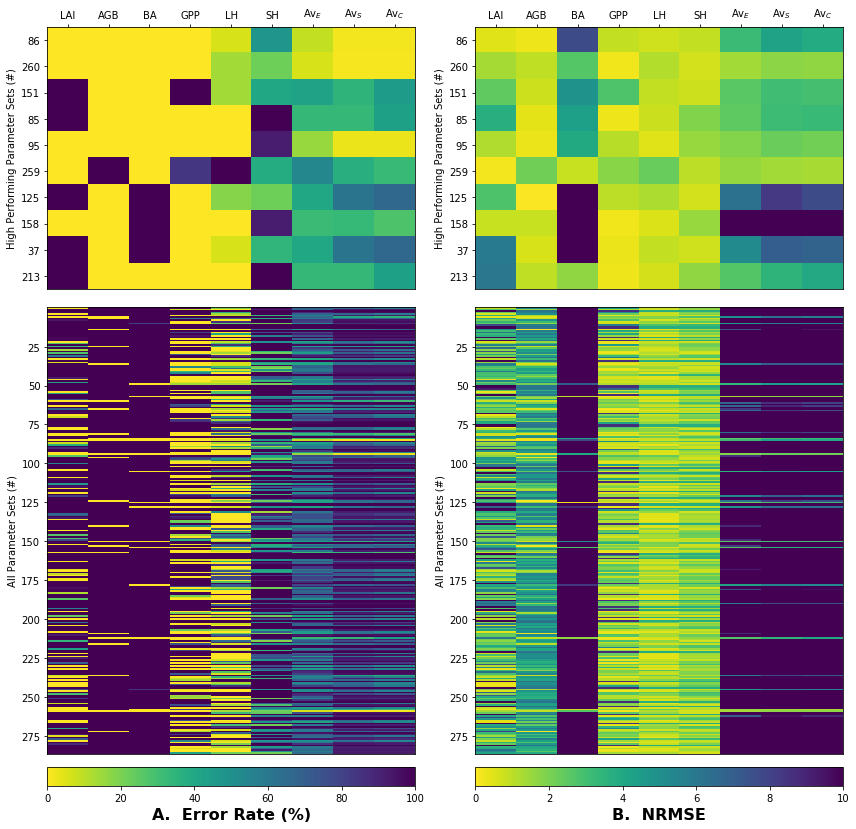

In [40]:
fig1 = plt.figure(figsize=(12,12))

# Set CO2levels index number
casenum = 0

# Plot Error Rate
plotnum = 1
heatsubplotfxn(error_heatdata, casenum, 0, 100, plotnum, 'A.  Error Rate (%)', 
               highperform_indx, heat_var_labels, ens10, enslist)

# Plot NRMSE
plotnum = plotnum+1
heatsubplotfxn(nrmse_heatdata, casenum, 0, 10, plotnum, 'B.  NRMSE', 
               highperform_indx, heat_var_labels, ens10, enslist)

plt.tight_layout()

__Figure 1.__ FATES model performance as measured by (A) error rate and (B) normalized root mean square error (NRMSE) for simulations run with 367 ppm atmospheric carbon dioxide. Performance metrics are shown for leaf area index (LAI), above-ground biomass (AGB), basal area (BA), gross primary productivity (GPP), latent heat flux (LH), sensible heat flux (SH) and weighted averages across variables using three weighting approaches:  even (Av$_E$), favoring structural variables (Av$_S$), and considering correlations (Av$_C$). Top panels highlight the performance of the top 10 highest-perfoming parameter sets. Bottom panels show the performance of all 287 parameter sets we tested.

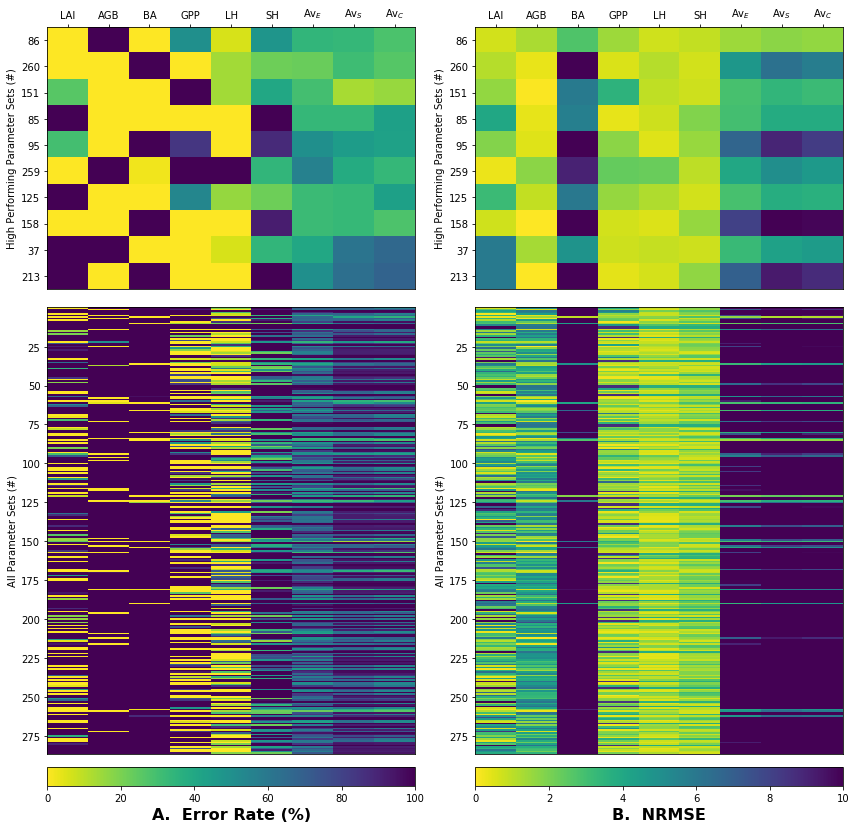

In [41]:
fig2 = plt.figure(figsize=(12,12))

# Set CO2levels index number
casenum = 1

# Plot Error Rate
plotnum = 1
heatsubplotfxn(error_heatdata, casenum, 0, 100, plotnum, 'A.  Error Rate (%)',
              highperform_indx, heat_var_labels, ens10, enslist)

# Plot NRMSE
plotnum = plotnum+1
heatsubplotfxn(nrmse_heatdata, casenum, 0, 10, plotnum, 'B.  NRMSE',
              highperform_indx, heat_var_labels, ens10, enslist)

plt.tight_layout()

__Figure 2.__ FATES model performance as measured by (A) error rate and (B) normalized root mean square error (NRMSE) for simulations run with 400 ppm atmospheric carbon dioxide. Performance metrics are shown for leaf area index (LAI), above-ground biomass (AGB), basal area (BA), gross primary productivity (GPP), latent heat flux (LH), sensible heat flux (SH) and weighted averages across variables using three weighting approaches:  even (Av$_E$), favoring structural variables (Av$_S$), and considering correlations (Av$_C$). Top panels highlight the performance of the top 10 highest-perfoming parameter sets. Bottom panels show the performance of all 287 parameter sets we tested.

## Results
This analysis identifies three high-performing parameter sets for use in future FATES simulations. We recommend the highest-performing parameter set (parameter set 86; Figures 1 and 2) as the primary parameter set for future experiments. Two other high-performing parameter sets (151 and 260; Figures 1 and 2) may be of interest for testing the sensitivity of simulation results to parameterization. Parameter set 260 is similar in parameter values and performance to the highest-performing parameter set (number 86). Parameter set 151 has the third highest performance but, has greater differences in key parameter values and results in a different simulated ecosystem. Specifically, parameter set 151 has higher performance in the above-ground biomass and basal area structural properties but, lower performance in leaf area index and gross primary productivity (Figures 1 and 2). These three high-performing parameter sets are publicly available through the University of Washington ResearchWorks digital repository at http://hdl.handle.net/1773/43779.


## Further Information
__Details of the parameter ensemble and analysis herein:__

Kovenock, M. (2019). Ecosystem and large-scale climate impacts of plant leaf dynamics (Doctoral dissertation). Chapter 4: "Within-canopy gradient of specific leaf area improves simulation of tropical forest structure and functioning in a demographic vegetation model." http://hdl.handle.net/1773/44061

__Details of the Functionally Assembled Ecosystem Simulator (FATES):__

https://github.com/NGEET/fates

Fisher, R. A., Koven, C. D., Anderegg, W. R., Christoffersen, B. O., Dietze, M. C., Farrior, C. E., et al. (2018). Vegetation demographics in Earth System Models: A review of progress and priorities. Global Change Biology, 24(1), 35–54. https://doi.org/10.1111/gcb.13910

Fisher, R. A., Muszala, S., Verteinstein, M., Lawrence, P., Xu, C., McDowell, N. G., et al. (2015). Taking off the training wheels: the properties of a dynamic vegetation model without climate envelopes. _Geoscientific Model Development, 8_(4), 3293–3357. https://doi.org/10.5194/gmdd-8-3293-2015


## References

Baraloto, C., Molto, Q., Rabaud, S., Hérault, B., Valencia, R., Blanc, L., et al. (2013). Rapid simultaneous estimation of aboveground biomass and tree diversity across Neotropical forests: a comparison of field inventory methods. _Biotropica, 45_(3), 288–298. https://doi.org/10.1111/btp.12006

Condit, R. (1998). Tropical forest census plots. Berlin, Germany, and Georgetown, Texas: Springer-Verlag and R. G. Landes Company.

Condit, R. S., Aguilar, S., Perez, R., Lao, S., Hubbell, S. P., & Foster, R. B. (2017). Barro Colorado 50-ha Plot Taxonomy as of 2017. https://doi.org/10.25570/stri/10088/32990

Condit, R., Lao, S., Pérez, R., Dolins, S. B., Foster, R., & Hubbell, S. (2012). Barro Colorado forest census plot data (version 2012). Center for Tropical Forest Science Databases. https://doi.org/10.5479/data.bci.20130603

Detto, M., Wright, S. J., Calderón, O., & Muller-Landau, H. C. (2018). Resource acquisition and reproductive strategies of tropical forest in response to the El Niño$-$Southern Oscillation. _Nature Communications, 9_(1), 913. https://doi.org/10.1038/s41467-018-03306-9

Faybishenko, B., Paton, S., Powell, T., Knox, R., Pastorello, G., Varadharajan, C., et al. (2018). QA/QC-ed BCI meteorological drivers. United States: Next-Generation Ecosystem Experiments Tropics; STRI; LBNL. https://doi.org/doi:10.15486/ngt/1423307

Feeley, K. J., Davies, S. J., Ashton, P. S., Bunyavejchewin, S., Supardi, M. N., Kassim, A. R., et al. (2007). The role of gap phase processes in the biomass dynamics of tropical forests. _Proceedings of the Royal Society B: Biological Sciences, 274_(1627), 2857–2864. https://doi.org/10.1098/rspb.2007.0954

Fisher, R. A., Koven, C. D., Anderegg, W. R., Christoffersen, B. O., Dietze, M. C., Farrior, C. E., et al. (2018). Vegetation demographics in Earth System Models: A review of progress and priorities. _Global Change Biology, 24_(1), 35–54. https://doi.org/10.1111/gcb.13910

Fisher, R. A., Muszala, S., Verteinstein, M., Lawrence, P., Xu, C., McDowell, N. G., et al. (2015). Taking off the training wheels: the properties of a dynamic vegetation model without climate envelopes. _Geoscientific Model Development, 8_(4), 3293–3357. https://doi.org/10.5194/gmdd-8-3293-2015

Hubbell, S. P., Foster, R. B., O'Brien, S. T., Harms, K. E., Condit, R., Wechsler, B., et al. (1999). Light-gap disturbances, recruitment limitation, and tree diversity in a neotropical forest. _Science, 283_(5401), 554–557. https://doi.org/10.1126/science.283.5401.554 

Koven, C. D., et al. (_in prep_). Benchmarking and parameter sensitivity of physiological and vegetation dynamics using the Functionally Assembled Terrestrial Ecosystem Simulator (FATES) at Barro Colorado Island, Panama.

Kovenock, M. (2019).  Ecosystem and large-scale climate impacts of plant leaf dynamics (Doctoral dissertation). http://hdl.handle.net/1773/44061

Meakem, V., Tepley, A. J., Gonzalez-Akre, E. B., Herrmann, V., Muller-Landau, H. C., Wright, S. J., et al. (2018). Role of tree size in moist tropical forest carbon cycling and water deficit responses. _New Phytologist, 219_, 947–958. https://doi.org/doi:10.1111/nph.14633
